# Defining gapfill media (vol. 3)

This part builds on the reconstruction with soft constraints. The models selected from that process are further used here. 


Strategy:
- **Make media based on..**
    - **product prediction of models able to grow**
    - **Filter by CHEBI class**

In [100]:
import pandas as pd
import reframed
import os
import json
import copy

import sys 
sys.path.append("../functions/")
import translation_dicts
import general_functions as general_func
import MAG_environments

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
compounds_dict, source_dict,substrate_dict, gas_sheet_dict, community_dict = translation_dicts.translation_dicts()

**Load data**

In [103]:
MAG2community_id= pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None,index_col=0)
MAG2community_id.columns=["community_id"]

In [104]:
all_mags_paper = general_func.read_allmags_data()

**Load models made without soft constraints**

In [105]:
directory = os 

directory = os.fsencode("../output/GEMs/GEMs_intermediate/GEMs_ACt2r/")

GEMs_dict = {}
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        print(filename)
        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("../output/GEMs/GEMs_intermediate/GEMs_ACt2r/"+filename)


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

### Define environment

In [106]:
syncon_environments = MAG_environments.community_syncon_environments()

syncon_environments.keys()

dict_keys(['CD_A', 'CD_P', 'CD_X', 'CM_A', 'CM_P', 'CM_X', 'M_P', 'M_X'])

### Determine abundance


**Get 99% most abundant species (>1%)**

In [107]:
relevant_MAGs = list(all_mags_paper[all_mags_paper["new_coverage"]>1].index)

In [108]:
len(relevant_MAGs)

72

## Modify Environment to support community growth

### FBA growth predictions (SynCon2)

In [109]:
community_groups = MAG2community_id.groupby(by="community_id").groups

In [110]:
FBA_growth = {}
for community_id, MAGs in community_groups.items(): 
    FBA_growth[community_id]={}
    for MAG in MAGs:
        if MAG in relevant_MAGs:
            print(MAG)
            model = GEMs_dict[MAG]
            syncon_environments[community_id].apply(model,inplace=True,exclusive=True,warning=False)
            sol = reframed.FBA(model)

            if sol is None:
                FBA_growth[community_id][MAG]=None
            else:
                FBA_growth[community_id][MAG]=sol

CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [111]:
# Add the source and substrate to this data
growth_community_df = pd.concat([MAG2community_id,pd.Series({GEM:sol.fobj for community_id,GEM_sol_dict in FBA_growth.items() for GEM,sol in GEM_sol_dict.items()})],axis=1)
# Change from float to False or positive
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)
# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

**When considering top 99 of members all but Cow_Manure on xylan have a growing community member**

In [112]:
growth_groupby = growth_community_df[growth_community_df.index.isin(all_mags_paper[all_mags_paper["new_coverage"]>1].index)]
MAG_can_grow = growth_community_df[growth_community_df.Grows].index

### FVA prediction of bacteria that can survive in the media (SynCon2) at obj_frac=0

1. Find compounds produced by growing community members
2. Filter by CHEBI class

#### Run FVA and find produced compounds

**Run FVA for exchange reactions of growing community members**

In [113]:
FVA_production = {}

for community_id, MAGs in community_groups.items(): 
    
    FVA_production[community_id]={}
    
    for MAG in MAGs:
        
        # If MAG is among the ones who cannot grow -> continue
        if MAG not in MAG_can_grow:
            continue
        print(MAG)
        
        model = GEMs_dict[MAG]
        
        # Apply medium
        syncon_environments[community_id].apply(model,inplace=True,exclusive=True,warning=False)
        # Find FVA solution and obj_frac=0
        FVA_production[community_id][MAG] = reframed.FVA(model,reactions=model.get_exchange_reactions(),obj_frac=0.0)
        

CH13-bin.2
CH15-bin.23
CH14-bin.1
CH8-bin.17
CH8-bin.6
CH8-bin.14
CH7-bin.16
CH7-bin.2
CH7-bin.1
CH7-bin.20
CH1-bin.8
CH1-bin.10
CH3-bin.2


**Find compounds that are being produced**

In [165]:
FVA_production_copy = FVA_production.copy()
FVA_production_copy = {community:{MAG:[rxn for rxn,sol in FVA_production_copy[community][MAG].items() if sol[1]>1e-6] for MAG in FVA_production_copy[community].keys()}
                       for community in FVA_production_copy.keys()}

**Combine the results from each community member into community level**

In [166]:
community_prod = {community_name:[] for community_name in FVA_production_copy.keys()}

for community_name,mag_prod in FVA_production_copy.items():
    for MAG,rxns in mag_prod.items():
        community_prod[community_name].extend(rxns)
    
    community_prod[community_name] = list(set(community_prod[community_name]))

#### Filter by chebi_class

In [167]:
# Some compounds are not interesting for us when it comes to exchange
ignore_classes = ["other","inorganic ions and atoms","oligopeptide","simple sugars","cellodextrin","carbohydrate derivative","carbohydrate acid","oligosaccharides"]

In [168]:
met_chebi_class = pd.read_csv("../output/met_chebi_class.tsv",sep="\t",index_col=0)

met_chebi_class_reduced = met_chebi_class[~met_chebi_class["self defined super class"].isin(ignore_classes)].copy()


met_chebi_class_reduced.loc["M_glc__D_e"]= met_chebi_class.loc["M_glc__D_e"]
met_chebi_class_reduced.loc["M_xyl__D_e"]= met_chebi_class.loc["M_xyl__D_e"]


In [169]:
met_chebi_class_reduced

,chebi id,chebi class,self defined super class
M_23camp_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
M_23ccmp_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
M_23cgmp_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
M_23cump_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
M_23dappa_e,CHEBI:33709,amino acid,amino acids and derivatives
...,...,...,...
M_tcynt_e,CHEBI:33261,organosulfur compound,organosulfur compounds
M_tma_e,CHEBI:35352,organonitrogen compound,organonitrogen compounds
M_tre6p_e,CHEBI:25710,organophosphorus compound,organophosphorus compounds
M_glc__D_e,CHEBI:35381,monosaccharide,simple sugars


In [170]:
met_chebi_class_dict = met_chebi_class_reduced["chebi class"].to_dict()

In [171]:
community_prod_dfs= {community_name: pd.DataFrame({"rxns":[rxn for rxn in rxns if "M_"+rxn[5:] in met_chebi_class_dict.keys() ],
                                                   "chebi_class":[met_chebi_class_dict["M_"+rxn[5:]] for rxn in rxns if "M_"+rxn[5:] in met_chebi_class_dict.keys() ]})
                                                  for community_name,rxns in community_prod.items()}

#### Plot data

In [172]:
community_prod_count_dfs ={}

for community_name, df in community_prod_dfs.items():
    
    community_prod_count_dfs[community_name] = df.groupby("chebi_class").count()

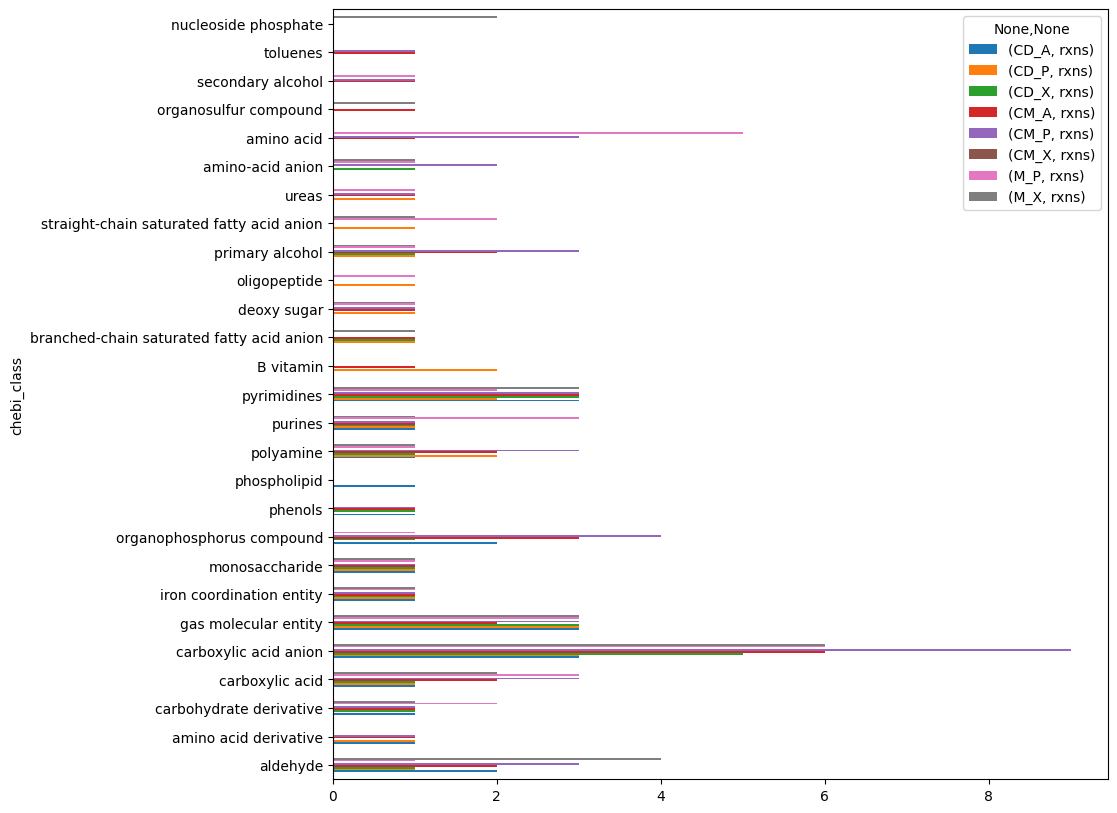

In [173]:
ax = pd.concat(community_prod_count_dfs,axis=1).fillna(0).plot(kind="barh",figsize=(10,10))

### Make new environments

In [174]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

In [175]:
substrate_dict = {'X': 'Xylan', 'A': 'Avicel', 'P': 'PASC'}
source_dict = {'M':'Marshland soil','CD':'Compost and Digestate', 'CM':'Cow manure'}

In [176]:
syncon_media = {}
for community_id in MAG2community_id.community_id.unique():
    
    # Mets from original syncon environment
    mets_syncon = [rxn[5:-2] for rxn in syncon_environments[community_id].keys()]
    
    # Mets produced by the community members
    mets_produced = [rxn[5:-2] for rxn in community_prod_dfs[community_id].rxns.values]
    mets_syncon.extend(mets_produced)

    syncon_media[community_id]=set(mets_syncon)

In [177]:
media_dfs = []

for community_id,compounds in syncon_media.items():
    media_id_list = community_id.split("_")

    source = media_id_list[0]
    substrate = media_id_list[1]

    # NB! Some of the compounds they used are not in the universal model!
    compounds = [met for met in compounds if "M_"+met+"_e" in model_uni.metabolites]
    compounds_names = [model_uni.metabolites["M_"+met+"_e"].name for met in compounds]
    
    media_df = pd.DataFrame({"medium":[community_id for met in compounds],
               "description": ["Media + produced compounds in "+source_dict[source]+" on " +substrate_dict[substrate] for met in compounds],
               "compound":compounds,
               "name":compounds_names})
    media_dfs.append(media_df)

In [179]:
media_total_df.to_csv("../output/gapfill_media/gapfill_media.tsv",sep="\t",index=None)